In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from toolz import reduce

In [2]:
def merge(left, right):
    return pd.merge(left, right, left_index=True, right_index=True, how='outer')

In [3]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-longv2-bambi", tight_layout=False)

In [4]:
keep_syllables = np.loadtxt(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
    dtype=int,
)
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet"
)

df = df[keep_syllables].astype(float)

fdf = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet"
)

fdf = fdf[keep_syllables].astype(float)

In [5]:
age = df.index.get_level_values("age")
bins = pd.cut(age, 40, labels=False)
sort_syllables = df.groupby(bins, observed=True).mean().quantile(0.95).sort_values(ascending=False).index

## Try looking at variance

In [6]:
windows = np.arange(1, 51)

n_sylls = 25
roll_size = 7

norms = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    cuts = pd.cut(m_age, windows)

    samples = []
    index = []
    for _bin, win_df in _df.groupby(cuts, observed=True):
        _sample = win_df.iloc[:2].mean()
        samples.append(_sample)
        index.append(win_df.index[0])
    samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))[sort_syllables[:n_sylls]]

    smooth_samples = samples.rolling(roll_size, center=True).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    norms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
    norms[mouse] = norms[mouse][~norms[mouse].index.duplicated(keep='first')]

norms = reduce(merge, norms.values())

mask = norms.isna().sum(1) < 10
norms = norms[mask]
norms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')
# Convert 'mouse' to category or string
#norms_melt['mouse'] = norms_melt['mouse'].astype('category')

fnorms = {}
for mouse, _df in fdf.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    cuts = pd.cut(m_age, windows)

    samples = []
    index = []
    for _bin, win_df in _df.groupby(cuts, observed=True):
        _sample = win_df.iloc[:2].mean()
        samples.append(_sample)
        index.append(win_df.index[0])
    samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))[sort_syllables[:n_sylls]]

    smooth_samples = samples.rolling(roll_size, center=True).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    fnorms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
    fnorms[mouse] = fnorms[mouse][~fnorms[mouse].index.duplicated(keep='first')]

fnorms = reduce(merge, fnorms.values())

mask = fnorms.isna().sum(1) < 10
fnorms = fnorms[mask]
fnorms_melt = fnorms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')
#fnorms_melt['mouse'] = fnorms_melt['mouse'].astype('category')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

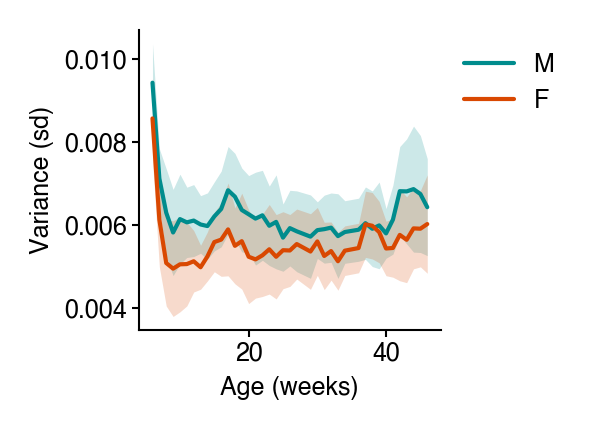

In [7]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=norms_melt, x='age', y='ar', errorbar='sd', err_kws=dict(lw=0), color=COLORMAPS.ont_male(255), label="M")
sns.lineplot(data=fnorms_melt, x='age', y='ar', errorbar='sd', ax=ax, err_kws=dict(lw=0), color=COLORMAPS.ont_female(255), label="F")
ax.set(ylabel="Variance (sd)", xlabel="Age (weeks)")
legend(ax)
sns.despine()

In [8]:
## stats

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

In [10]:
import statsmodels.formula.api as smf

def ow_anova(data, dependent_var, factor1):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    model = ols(f'ranked_response ~ {factor1}', data=align_data).fit()
    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df



def fit_1mixed_linear_models(data, dependent_var, factor1, group):
    
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]

    #formula = f'ranked_response ~ {factor1}*{group}'
    formula = f'ranked_response ~ {factor1}'
        
    # Fit the mixed linear model
    model = smf.mixedlm(formula, align_data, groups=f'{group}')
    result = model.fit()
    return result


def fit_2mixed_linear_models(data, dependent_var, factor1,factor2, group):
    
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    formula = f'ranked_response ~ {factor1}*C({factor2})'
        
    # Fit the mixed linear model
    model = smf.mixedlm(formula, align_data, groups=f'{group}')
    result = model.fit()
    return result


def extract_summary_to_dataframe(results, num_tests):
    summary_data = []

    for var, result in results.items():
        summary = result.summary()
        coefs = result.params
        pvalues = result.pvalues
        conf_int = result.conf_int()
        
        for param in coefs.index:
            pvalue_corrected = min(pvalues[param] * num_tests, 1.0)  # Apply Bonferroni correction
            
            summary_data.append({
                'Dependent Variable': var,
                'Parameter': param,
                'Coefficient': coefs[param],
                'P-value': pvalues[param],
                'Corrected P-value': pvalue_corrected,
                'CI Lower': conf_int[0][param],
                'CI Upper': conf_int[1][param]
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [11]:
mdf = norms_melt.copy()
fdf = fnorms_melt.copy()

fdf['sex']=str('f')
mdf['sex']=str('m')

data = pd.concat([mdf, fdf], ignore_index=True)

In [12]:
results={}

syll = ['ar']
temp = data.dropna().copy()
temp.reset_index(inplace=True)

for i in syll:
    result=fit_2mixed_linear_models(temp, i, 'age','sex','mouse')
    results[i] = result
num_tests = len(data.columns)  # Number of tests is the number of dependent variables (excluding 'age' and 'mouse')
summary_df = extract_summary_to_dataframe(results, num_tests)

# Print the DataFrame nicely
print(summary_df)
summary_df.to_csv('/n/groups/datta/Dana/Ontogeny/figs/fig4/aging_rate_fvm.csv')

  Dependent Variable        Parameter  Coefficient       P-value  \
0                 ar        Intercept     0.005501  0.000000e+00   
1                 ar      C(sex)[T.m]     0.001045  5.015184e-09   
2                 ar              age     0.000002  6.042925e-01   
3                 ar  age:C(sex)[T.m]    -0.000013  3.419247e-03   
4                 ar        mouse Var     0.158710  2.207138e-04   

   Corrected P-value  CI Lower  CI Upper  
0       0.000000e+00  0.005254  0.005748  
1       2.006074e-08  0.000694  0.001395  
2       1.000000e+00 -0.000004  0.000008  
3       1.367699e-02 -0.000021 -0.000004  
4       8.828551e-04  0.074503  0.242917  


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
